In [1]:
import numpy as np
import random
from tvb.simulator.lab import *
from scipy.stats import zscore
import scipy.io as sio
import pandas as pd
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from itertools import product
from plots.ssdigraphs import plot_connectivity, plot_nodeweights_individual



2023-07-17 15:14:45,318 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


/Users/borjanmilinkovic/opt/anaconda3/envs/tvb-run/lib/python3.10/site-packages/tvb/datatypes/surfaces.py:63: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


WARNING  File 'hemispheres' not found in ZIP.


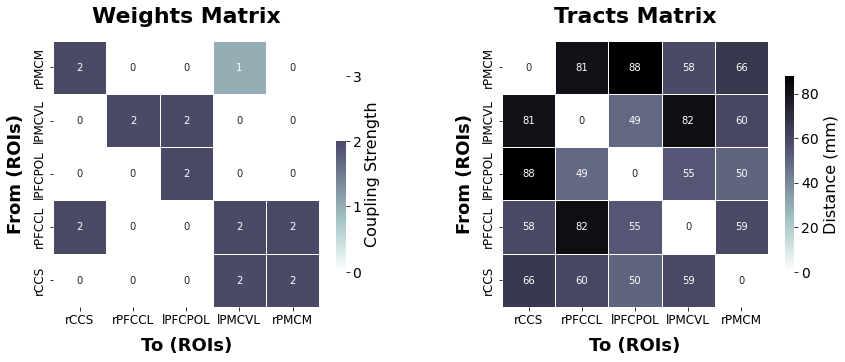

In [8]:
# INITIALISE DIRECTORIES FOR SAVING DATA AND FIGURES

resultsDir = '/Users/borjanmilinkovic/Documents/gitdir/TVBEmergence/results/'
dataDir = os.path.join(resultsDir, 'TEST_SJ3D_ps_gc-noise/data/')
figureDir = os.path.join(resultsDir, 'TEST_SJ3D_ps_gc-noise/figures/')
connDir = os.path.join(resultsDir, 'TEST_SJ3D_ps_gc-noise/conn/')

os.makedirs(dataDir, exist_ok=True)
os.makedirs(figureDir, exist_ok=True)
os.makedirs(connDir, exist_ok=True)

# INITIALISE CONNECTIVITY
default = connectivity.Connectivity.from_file()
default.configure()

idx = np.r_[random.sample(range(0, 75), 5)] # <-- get a row and columnar index for specific subset of regions

# configure weights structural and connectivity
# changedWeights = np.array([[0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0]])

# tracts_nodelay = np.array([[0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0],
#                            [0, 0, 0, 0, 0]])

subset = connectivity.Connectivity(weights=default.weights[idx][:, idx],
                                           tract_lengths=default.tract_lengths[idx][:, idx],
                                           centres=default.centres[idx],
                                           region_labels=default.region_labels[idx])
subset.configure()
plot_connectivity(subset)

regions = subset.region_labels # <-- this is the subset of region labels, save for later use in plotting



In [3]:
# INITIALISE SIMULATOR

monitors = monitors.TemporalAverage(period=3.90625) # <-- 256 Hz sampling rate

# Initialise model
simulation = simulator.Simulator(connectivity=subset,
                                 coupling=coupling.Linear(), # <-- linear coupling
                                 integrator=integrators.HeunStochastic(dt=2**-6, 
                                                                       noise=noise.Additive()), # <-- 2**-6 integration step size 
                                 monitors=[monitors], # <-- monitors
                                 model=models.ReducedSetHindmarshRose(), # <-- reduced set HR model
                                 simulation_length=4000) # <-- 4000 ms simulation
simulation.configure() # <-- configure the simulator

# RUN SIMULATION
# define function for running simulation

def run_sim(global_coupling, noise): 
    simulation.coupling.a = global_coupling # <-- set global coupling
    simulation.integrator.noise.nsig = noise # <-- set noise
    print("Starting SJ3D simulation with coupling factor: " + str(global_coupling) + " and noise: " + str(noise)) # <-- print to console
    results = simulation.run() # <-- run simulation
    time = results[0][0].squeeze() # <-- get time vector
    data = results[0][1].squeeze() # <-- get data
    data_cleaned = np.zeros([5, 1024])  # initialise structure for z-scored data.
    for i in range(len(default.weights)): # z-score data
        data_cleaned[i] = zscore(np.sum(data[:, 0, i, :], axis=1)) 
    return (global_coupling, noise, data_cleaned, time) # <-- return data



In [8]:
range(len(subset.weights))



range(0, 5)

In [ ]:
# run simulation for different global coupling and noise values

global_coupling_log = 10**np.r_[-2:-0.5:20j] # <-- logspace for global coupling
noise_log = 10**np.r_[-3:-0.002:20j] # <-- logspace for noise

data = [] # <-- initialise results structure

for (ai, bi) in list(product(*[global_coupling_log, noise_log])): # <-- loop over global coupling and noise values
    data.append(run_sim(np.array([ai]), np.array([bi]))) # <-- run simulation and append to results structure



In [ ]:
# SAVE DATA

np.save(os.path.join(dataDir, 'results.npy'), results) # <-- save results structure as numpy array

data_dict = {} # <-- initialise data dictionary
data_dict['results'] = results # <-- add results structure to data dictionary
sio.savemat(os.path.join(dataDir, 'results.mat'), data_dict) # <-- save data dictionary as mat file

# view results structure shape and size
print(results.shape)
print(results.size)

10**-6

In [19]:
10**0.3


1.9952623149688795

In [22]:
10**-0.001


0.9977000638225533